# 01 - Data Exploration

This notebook explores the vehicle positions and GTFS transit data.

## Steps:
1. Load vehicle positions CSV
2. Load GTFS stop_times data
3. Explore data structure and basic statistics
4. Visualize delays and patterns


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append(str(Path('../src').resolve()))
from data_utils import (
    load_gtfs_data, 
    load_vehicle_positions,
    preprocess_gtfs,
    merge_vehicle_positions_with_stop_times
)
from features import extract_all_features

# Set up paths
data_dir = Path('../data/raw')
processed_dir = Path('../data/processed')
processed_dir.mkdir(parents=True, exist_ok=True)

print("=" * 60)
print("Data Exploration - Transit Tracker")
print("=" * 60)


Data Exploration - Transit Tracker


## 1. Load Vehicle Positions Data


In [2]:
# Load vehicle positions
vehicle_positions_file = 'vehicle_positions_rt_rows-11-13.csv'
vehicle_positions = load_vehicle_positions(data_dir / vehicle_positions_file)

print(f"\nVehicle Positions Shape: {vehicle_positions.shape}")
print(f"\nColumns: {list(vehicle_positions.columns)}")
print(f"\nFirst few rows:")
vehicle_positions.head()



Vehicle Positions Shape: (574123, 16)

Columns: ['id', 'trip_id', 'route_id', 'start_date', 'schedule_relationship', 'vehicle_id', 'vehicle_label', 'latitude', 'longitude', 'bearing', 'speed', 'stop_id', 'current_status', 'timestamp', 'current_stop_sequence', 'datetime']

First few rows:


,id,trip_id,route_id,start_date,schedule_relationship,vehicle_id,vehicle_label,latitude,longitude,bearing,speed,stop_id,current_status,timestamp,current_stop_sequence,datetime
0,10002,10910002140434-JUNE25,910-13188,20251113,SCHEDULED,10002,10002,33.869340,-118.287605,NaN,0.0,30005,STOPPED_AT,1763037712,1,2025-11-13 12:41:52
1,10002,10910002140434-JUNE25,910-13188,20251113,SCHEDULED,10002,10002,33.869343,-118.287605,NaN,0.0,30005,STOPPED_AT,1763037734,1,2025-11-13 12:42:14
2,10002,10910002140434-JUNE25,910-13188,20251113,SCHEDULED,10002,10002,33.869343,-118.287605,NaN,0.0,30005,STOPPED_AT,1763037755,1,2025-11-13 12:42:35
3,10002,10910002140434-JUNE25,910-13188,20251113,SCHEDULED,10002,10002,33.869343,-118.287605,NaN,0.0,30005,STOPPED_AT,1763037776,1,2025-11-13 12:42:56
4,10002,10910002140434-JUNE25,910-13188,20251113,SCHEDULED,10002,10002,33.869340,-118.287610,NaN,0.0,30005,STOPPED_AT,1763037794,1,2025-11-13 12:43:14


In [3]:
# Basic statistics
print("\n=== Vehicle Positions Statistics ===")
print(f"Total records: {len(vehicle_positions):,}")
print(f"Unique routes: {vehicle_positions['route_id'].nunique()}")
print(f"Unique trips: {vehicle_positions['trip_id'].nunique()}")
print(f"Unique vehicles: {vehicle_positions['vehicle_id'].nunique()}")
print(f"Unique stops: {vehicle_positions['stop_id'].nunique()}")
print(f"\nDate range: {vehicle_positions['datetime'].min()} to {vehicle_positions['datetime'].max()}")
print(f"\nRoute distribution (top 10):")
vehicle_positions['route_id'].value_counts().head(10)



=== Vehicle Positions Statistics ===
Total records: 574,123
Unique routes: 108
Unique trips: 2853
Unique vehicles: 1455
Unique stops: 11591

Date range: 2025-11-13 12:33:01 to 2025-11-13 15:44:36

Route distribution (top 10):


route_id
720-13188    16565
51-13188     14102
108-13188    13119
60-13188     12990
4-13188      12968
207-13188    12140
33-13188     12063
2-13188      11837
910-13188    11773
16-13188     11463
Name: count, dtype: int64

## 2. Load GTFS Stop Times Data


In [4]:
# Load GTFS data
gtfs_data = load_gtfs_data(data_dir)
print("Loaded GTFS files:", list(gtfs_data.keys()))

# Preprocess GTFS
gtfs_data = preprocess_gtfs(gtfs_data)

# Explore stop_times
if 'stop_times' in gtfs_data:
    stop_times = gtfs_data['stop_times']
    print(f"\nStop Times Shape: {stop_times.shape}")
    print(f"\nStop Times Columns: {list(stop_times.columns)}")
    print(f"\nUnique trips in stop_times: {stop_times['trip_id'].nunique()}")
    print(f"\nUnique stops in stop_times: {stop_times['stop_id'].nunique()}")
    stop_times.head()


Loaded GTFS files: ['stop_times']

Stop Times Shape: (2098728, 15)

Stop Times Columns: ['trip_id', 'arrival_time', 'departure_time', 'stop_id', 'stop_sequence', 'stop_headsign', 'pickup_type', 'drop_off_type', 'trip_id_event', 'route_code', 'destination_code', 'timepoint', 'bay_num', 'arrival_time_seconds', 'departure_time_seconds']

Unique trips in stop_times: 33412

Unique stops in stop_times: 11839


## 3. Merge Vehicle Positions with Stop Times


In [5]:
# Merge data (using a sample for faster exploration)
# Take a sample of vehicle positions for exploration
sample_size = min(10000, len(vehicle_positions))
vehicle_sample = vehicle_positions.sample(n=sample_size, random_state=42)

# Merge with stop_times
merged_data = merge_vehicle_positions_with_stop_times(
    vehicle_sample,
    gtfs_data['stop_times']
)

print(f"Merged data shape: {merged_data.shape}")
print(f"\nMerge success rate: {(merged_data['arrival_time'].notna().sum() / len(merged_data) * 100):.1f}%")
print(f"\nMerged columns: {list(merged_data.columns)}")
merged_data.head()


Merged data shape: (10040, 29)

Merge success rate: 100.0%

Merged columns: ['id', 'trip_id', 'route_id', 'start_date', 'schedule_relationship', 'vehicle_id', 'vehicle_label', 'latitude', 'longitude', 'bearing', 'speed', 'stop_id', 'current_status', 'timestamp', 'current_stop_sequence', 'datetime', 'arrival_time', 'departure_time', 'stop_sequence', 'stop_headsign', 'pickup_type', 'drop_off_type', 'trip_id_event', 'route_code', 'destination_code', 'timepoint', 'bay_num', 'arrival_time_seconds', 'departure_time_seconds']


,id,trip_id,route_id,start_date,schedule_relationship,vehicle_id,vehicle_label,latitude,longitude,bearing,...,stop_headsign,pickup_type,drop_off_type,trip_id_event,route_code,destination_code,timepoint,bay_num,arrival_time_seconds,departure_time_seconds
0,1599,10081003730541-JUNE25,81-13188,20251113,SCHEDULED,1599,1599,34.087100,-118.224205,NaN,...,81 - Figueroa - La Loma,1,1,62057056-JUNE25-D03CAR-1_Weekday,81.0,Figueroa - La Loma,1,NaN,20460,20460
1,3953,10030008280623-JUNE25,30-13188,20251113,SCHEDULED,3953,3953,34.057060,-118.231255,NaN,...,30 - Pico - Rimpau,0,0,62081344-JUNE25-D13CAR-1_Weekday,30.0,Pico - Rimpau,1,NaN,22980,22980
2,1949,10166000860435-JUNE25,166-13188,20251113,SCHEDULED,1949,1949,34.235600,-118.529560,269.0,...,166 - Nordhoff - Canoga,0,0,61917457-JUNE25-D15CAR-1_Weekday,166.0,Nordhoff - Canoga,0,NaN,18240,18240
3,5837,10035002870629-JUNE25,35-13188,20251113,SCHEDULED,5837,5837,34.035046,-118.369225,NaN,...,38 - Downtown LA - Broadway - Venice,1,1,62061001-JUNE25-D07CAR-1_Weekday,38.0,Downtown LA - Broadway - Venice,1,NaN,23340,23340
4,5837,10035002870629-JUNE25,35-13188,20251113,SCHEDULED,5837,5837,34.035046,-118.369225,NaN,...,35 - Washington / Fairfax Transit Hub,1,1,62061001-JUNE25-D07CAR-1_Weekday,35.0,Washington / Fairfax Transit Hub,1,NaN,28140,28140


## 4. Extract Features and Explore Delays


In [ ]:
# Reload features module to pick up code changes
import importlib
from pathlib import Path
import sys

# Ensure src is in path
sys.path.append(str(Path('../src').resolve()))

# Reload the features module
import features
importlib.reload(features)
from features import extract_all_features

# Check if merged_data exists (created in Cell 8)
if 'merged_data' not in globals():
    raise NameError(
        "❌ 'merged_data' is not defined. Please run the previous cells in order:\n"
        "  1. Cell 1: Imports and setup\n"
        "  2. Cell 3: Load vehicle positions\n"
        "  3. Cell 6: Load GTFS data\n"
        "  4. Cell 8: Merge data (creates merged_data)\n"
        "  5. Then run this cell (Cell 10)"
    )

# Extract all features
features_df = extract_all_features(merged_data)

print(f"Features shape: {features_df.shape}")
print(f"\nFeature columns: {len(features_df.columns)} columns")

# Check delay statistics if available
if 'arrival_delay_minutes' in features_df.columns:
    delays = features_df['arrival_delay_minutes'].dropna()
    print(f"\n=== Delay Statistics ===")
    print(f"Mean delay: {delays.mean():.2f} minutes")
    print(f"Median delay: {delays.median():.2f} minutes")
    print(f"Std delay: {delays.std():.2f} minutes")
    print(f"Min delay: {delays.min():.2f} minutes")
    print(f"Max delay: {delays.max():.2f} minutes")
    print(f"On-time percentage (±1 min): {((delays >= -1) & (delays <= 1)).sum() / len(delays) * 100:.1f}%")


Features shape: (10040, 71)

Feature columns: 71 columns

=== Delay Statistics (Primary: seconds) ===
Mean delay: 537.70 seconds (8.96 minutes)
Median delay: 197.50 seconds (3.29 minutes)
Std delay: 845.23 seconds (14.09 minutes)
Min delay: -5040.00 seconds (-84.00 minutes)
Max delay: 7259.00 seconds (120.98 minutes)
On-time percentage (±60 seconds): 35.1%
On-time percentage (±5 minutes): 54.5%


## 5. Visualizations


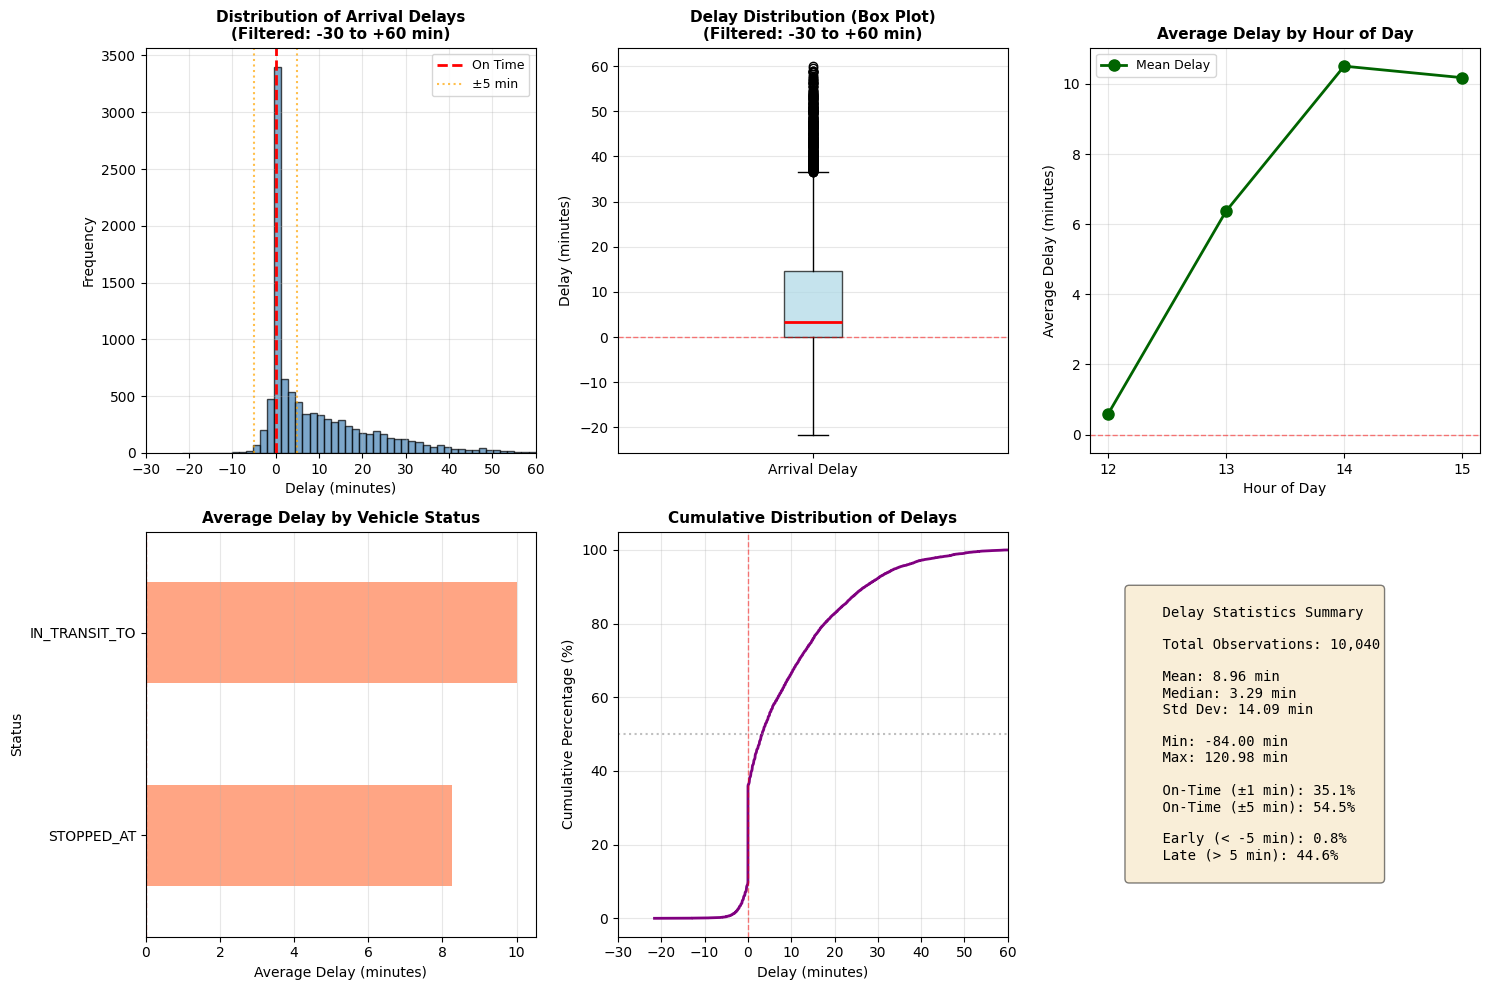

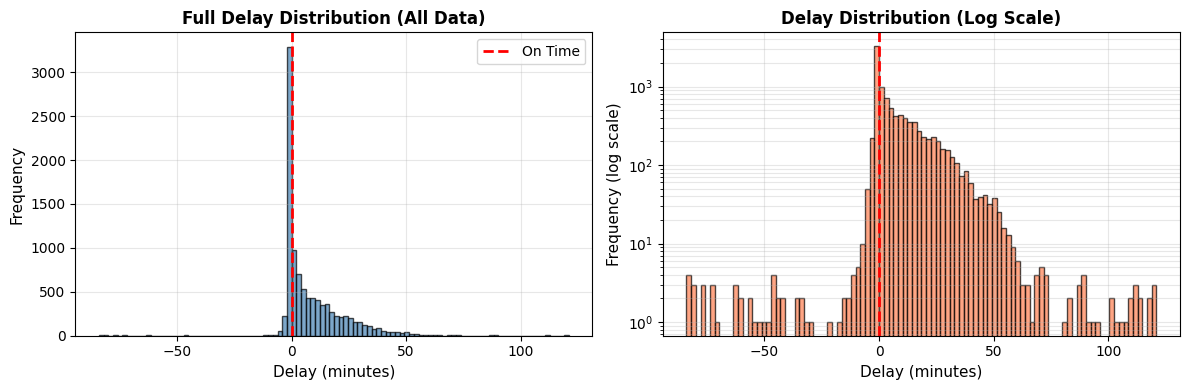

In [ ]:
# Plot delay distribution
if 'arrival_delay_minutes' in features_df.columns:
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    delays = features_df['arrival_delay_minutes'].dropna()
    plt.hist(delays, bins=50, edgecolor='black', alpha=0.7)
    plt.xlabel('Delay (minutes)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Arrival Delays')
    plt.axvline(x=0, color='r', linestyle='--', label='On Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    if 'hour' in features_df.columns:
        hourly_delays = features_df.groupby('hour')['arrival_delay_minutes'].mean()
        plt.plot(hourly_delays.index, hourly_delays.values, marker='o')
        plt.xlabel('Hour of Day')
        plt.ylabel('Average Delay (minutes)')
        plt.title('Average Delay by Hour')
        plt.grid(True, alpha=0.3)
        plt.xticks(range(24))
    
    plt.tight_layout()
    plt.show()


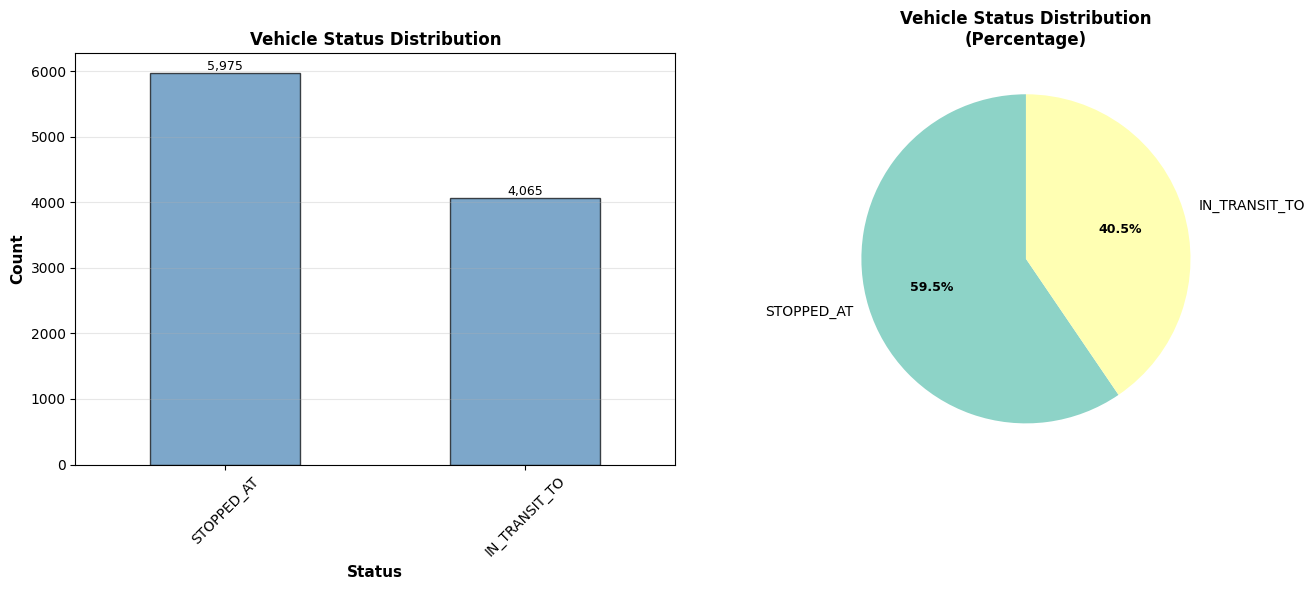


=== Status Breakdown ===
current_status
STOPPED_AT       5975
IN_TRANSIT_TO    4065
Name: count, dtype: int64

Total observations: 10,040
Percentage distribution:
  STOPPED_AT: 59.51%
  IN_TRANSIT_TO: 40.49%


In [ ]:
# Status breakdown
if 'current_status' in features_df.columns:
    status_counts = features_df['current_status'].value_counts()
    plt.figure(figsize=(8, 6))
    status_counts.plot(kind='bar')
    plt.xlabel('Status')
    plt.ylabel('Count')
    plt.title('Vehicle Status Distribution')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\nStatus breakdown:")
    print(status_counts)


## 6. Save Processed Data for Next Steps

Save a sample of the processed data for feature engineering and model training.


In [17]:
# Save features for next notebook
# For full dataset, remove .sample() and process all data
features_df.to_csv(processed_dir / 'explored_features.csv', index=False)
print(f"Saved features to {processed_dir / 'explored_features.csv'}")
print(f"Shape: {features_df.shape}")


Saved features to ../data/processed/explored_features.csv
Shape: (10040, 71)
